# Вариант 3. Построение модели и оптимизация гиперпараметров.
Данный вариант предполагает фокусировку на процессе улучшения эффективности модели обучения с учителем. Студенту следует подготовить датасет к обучению, обучить одну из моделей с учителем со значениями гиперпараметров по умолчанию, получить значение эффективности. После этого вручную или автоматически подобрать значения гиперпараметров таким образом, чтобы получить максимальный прирост эффективности.

In [ ]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [ ]:
dataset = pd.read_csv('german_credit_data.csv')
dataset

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [ ]:
dataset.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [ ]:
dataset.describe(include='O')

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk
count,1000,1000,817,606,1000,1000
unique,2,3,4,3,8,2
top,male,own,little,little,car,good
freq,690,713,603,274,337,700


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


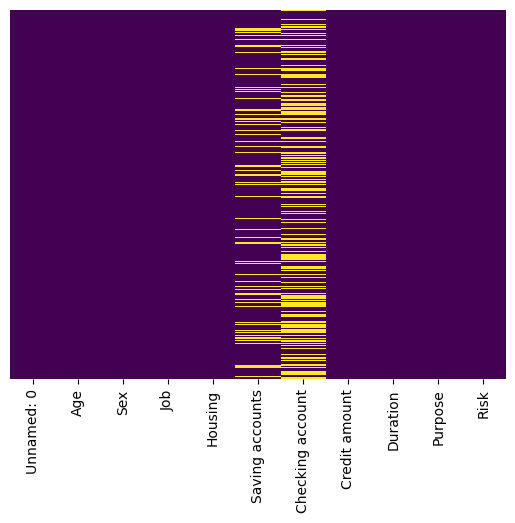

In [ ]:
sns.heatmap(dataset.isnull(), yticklabels=False, cbar=False, cmap='viridis');

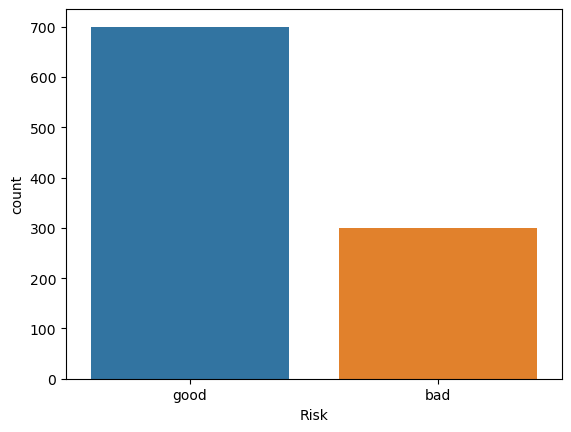

In [ ]:
sns.countplot(x='Risk', data=dataset);

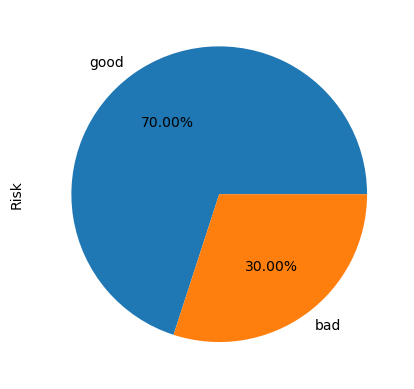

In [ ]:
dataset['Risk'].value_counts().plot(kind='pie',autopct='%.2f%%');

In [ ]:
for col in dataset.columns:
    dataset[col].fillna(dataset[col].mode()[0], inplace=True)

In [ ]:
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,little,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,little,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,little,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [ ]:
label_encoder = LabelEncoder()
dataset['Sex'] = label_encoder.fit_transform(dataset['Sex'])
dataset['Housing'] = label_encoder.fit_transform(dataset['Housing'])
dataset['Saving accounts'] = label_encoder.fit_transform(dataset['Saving accounts'])
dataset['Checking account'] = label_encoder.fit_transform(dataset['Checking account'])
dataset['Purpose'] = label_encoder.fit_transform(dataset['Purpose'])
dataset['Risk'] = label_encoder.fit_transform(dataset['Risk'])
dataset

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,0,1169,6,5,1
1,22,0,2,1,0,1,5951,48,5,0
2,49,1,1,1,0,0,2096,12,3,1
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,0,0,1736,12,4,1
996,40,1,3,1,0,0,3857,30,1,1
997,38,1,2,1,0,0,804,12,5,1
998,23,1,2,0,0,0,1845,45,5,0


In [ ]:
X = dataset.drop('Risk', axis=1)
y = dataset['Risk']

In [ ]:
model_log = LogisticRegression()

scores = cross_val_score(model_log, X, y, cv=5, scoring='accuracy')

print("accuracy на каждом фолде:", scores)
print("Средняя accuracy на кросс-валидации:", scores.mean())

accuracy на каждом фолде: [0.705 0.71  0.725 0.7   0.75 ]
Средняя accuracy на кросс-валидации: 0.718


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'max_iter': [10000],
    'penalty': ['l1', 'l2'],  # Тип регуляризации
    'C': [0.1, 1.0],  # Обратная сила регуляризации
    'solver': ['liblinear', 'saga']  # Алгоритм оптимизации
}

grid_search_log = GridSearchCV(estimator=model_log, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search_log.fit(X_train, y_train)

best_params = grid_search_log.best_params_
print("Лучшие гиперпараметры:", best_params)

Лучшие гиперпараметры: {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
def train_run_models_kf(X, y):
    metrics = {
        'Accuracy': make_scorer(accuracy_score),
        'Precision': make_scorer(precision_score, average='weighted'),
        'Recall': make_scorer(recall_score, average='weighted'),
        'F1-Score': make_scorer(f1_score, average='weighted'),
        'ROC-AUC': make_scorer(roc_auc_score)
    }

    models = [
        ('Логистическая регрессия', LogisticRegression()),
    ]

    acc_dict = {}
    for name, model in models:
        model_scores = {}
        for metric_name, scorer in metrics.items():
            cv_results = cross_val_score(grid_search_log.best_estimator_, X, y, cv=4, scoring=scorer, n_jobs=-1)
            model_scores[metric_name] = cv_results.mean()

        acc_dict[name] = model_scores

    acc_df = pd.DataFrame.from_dict(acc_dict, orient='index')
    display(acc_df)

train_run_models_kf(X, y)

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Логистическая регрессия,0.71,0.679591,0.71,0.640143,0.545238


In [ ]:
model_mlp = MLPClassifier()
scores = cross_val_score(model_mlp, X, y, cv=5, scoring='accuracy')

print("accuracy на каждом фолде:", scores)
print("Средняя accuracy на кросс-валидации:", scores.mean())

accuracy на каждом фолде: [0.66  0.7   0.7   0.7   0.645]
Средняя accuracy на кросс-валидации: 0.6809999999999999


In [ ]:
param_grid = {
    'max_iter' :[500],
    'hidden_layer_sizes': [(50, 50), (30, 30, 30)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.001, 0.01]
}

grid_search_mlp = GridSearchCV(estimator=model_mlp, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search_mlp.fit(X_train, y_train)

best_params = grid_search_mlp.best_params_
print("Лучшие гиперпараметры:", best_params)

Лучшие гиперпараметры: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'max_iter': 500}


In [ ]:
def train_run_models_kf(X, y):
    metrics = {
        'Accuracy': make_scorer(accuracy_score),
        'Precision': make_scorer(precision_score, average='weighted'),
        'Recall': make_scorer(recall_score, average='weighted'),
        'F1-Score': make_scorer(f1_score, average='weighted')
    }

    models = [
        ('Многослойный перцептрон', MLPClassifier()),
    ]

    acc_dict = {}
    for name, model in models:
        model_scores = {}
        for metric_name, scorer in metrics.items():
            cv_results = cross_val_score(grid_search_mlp.best_estimator_, X, y, cv=4, scoring=scorer, n_jobs=-1)
            model_scores[metric_name] = cv_results.mean()

        acc_dict[name] = model_scores

    acc_df = pd.DataFrame.from_dict(acc_dict, orient='index')
    display(acc_df)

train_run_models_kf(X, y)

,Accuracy,Precision,Recall,F1-Score
Многослойный перцептрон,0.701,0.515071,0.7,0.584271


In [ ]:
model_dtree = DecisionTreeClassifier()
scores = cross_val_score(model_dtree, X, y, cv=5, scoring='accuracy')

print("accuracy на каждом фолде:", scores)
print("Средняя accuracy на кросс-валидации:", scores.mean())

accuracy на каждом фолде: [0.65  0.645 0.63  0.645 0.62 ]
Средняя accuracy на кросс-валидации: 0.638


In [ ]:
param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_dtree = GridSearchCV(estimator=model_dtree, param_grid=param_grid, scoring='accuracy', cv=3)

grid_search_dtree.fit(X_train, y_train)

best_params = grid_search_dtree.best_params_
print("Лучшие гиперпараметры:", best_params)

Лучшие гиперпараметры: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [ ]:
def train_run_models_kf(X, y):
    metrics = {
        'Accuracy': make_scorer(accuracy_score),
        'Precision': make_scorer(precision_score, average='weighted'),
        'Recall': make_scorer(recall_score, average='weighted'),
        'F1-Score': make_scorer(f1_score, average='weighted')
    }

    models = [
        ('Дерево решений', DecisionTreeClassifier()),
    ]

    acc_dict = {}
    for name, model in models:
        model_scores = {}
        for metric_name, scorer in metrics.items():
            cv_results = cross_val_score(grid_search_dtree.best_estimator_, X, y, cv=4, scoring=scorer, n_jobs=-1)
            model_scores[metric_name] = cv_results.mean()

        acc_dict[name] = model_scores

    acc_df = pd.DataFrame.from_dict(acc_dict, orient='index')
    display(acc_df)

train_run_models_kf(X, y)

,Accuracy,Precision,Recall,F1-Score
Дерево решений,0.7,0.669304,0.701,0.651665


In [ ]:
model_gb = GradientBoostingClassifier()
scores = cross_val_score(model_gb, X, y, cv=5, scoring='accuracy')

print("accuracy на каждом фолде:", scores)
print("Средняя accuracy на кросс-валидации:", scores.mean())

accuracy на каждом фолде: [0.715 0.72  0.67  0.68  0.665]
Средняя accuracy на кросс-валидации: 0.6900000000000001


In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10]
}

grid_search_gb = GridSearchCV(estimator=model_gb, param_grid=param_grid, scoring='accuracy', cv=3)

grid_search_gb.fit(X_train, y_train)

best_params = grid_search_gb.best_params_
print("Лучшие гиперпараметры:", best_params)

Лучшие гиперпараметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [ ]:
def train_run_models_kf(X, y):
    metrics = {
        'Accuracy': make_scorer(accuracy_score),
        'Precision': make_scorer(precision_score, average='weighted'),
        'Recall': make_scorer(recall_score, average='weighted'),
        'F1-Score': make_scorer(f1_score, average='weighted')
    }

    models = [
        ('Градиентный бустинг', GradientBoostingClassifier()),
    ]

    acc_dict = {}
    for name, model in models:
        model_scores = {}
        for metric_name, scorer in metrics.items():
            cv_results = cross_val_score(grid_search_dtree.best_estimator_, X, y, cv=4, scoring=scorer, n_jobs=-1)
            model_scores[metric_name] = cv_results.mean()

        acc_dict[name] = model_scores

    acc_df = pd.DataFrame.from_dict(acc_dict, orient='index')
    display(acc_df)

train_run_models_kf(X, y)

,Accuracy,Precision,Recall,F1-Score
Градиентный бустинг,0.701,0.670389,0.703,0.654021
